# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217405

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [ ]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                       net.regularized_loss, 
                                                       ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})
                        train_batch()

                        count = 10
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -=1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test_, 
                                                                             net.y_: preprocess.y_test_, 
                                                                             net.keep_prob:1, net.lr:lr})
                    
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, test_loss, accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_vae_loss_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
                        Train.best_acc = accuracy

                        if(not np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})



In [ ]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [30]
    lrs = [1e-2, 1e-2/4, 1e-2/4]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.001541 | Test Loss: 0.017236 | Test Accuracy: 0.846212, 0.752574
Step 2 | Training Loss: 0.000369 | Test Loss: 0.009777 | Test Accuracy: 0.776215, 0.700591
Step 3 | Training Loss: 0.000033 | Test Loss: 0.011150 | Test Accuracy: 0.754613, 0.637468
Step 4 | Training Loss: 0.000475 | Test Loss: 0.012280 | Test Accuracy: 0.735185, 0.623629
Step 5 | Training Loss: 0.001026 | Test Loss: 0.009663 | Test Accuracy: 0.704223, 0.726329
Step 6 | Training Loss: 0.000479 | Test Loss: 0.008579 | Test Accuracy: 0.729950, 0.622532
Step 7 | Training Loss: 0.000330 | Test Loss: 0.009727 | Test Accuracy: 0.721611, 0.704219
Step 8 | Training Loss: 0.001256 | Test Loss: 0.008351 | Test Accuracy: 0.709280, 0.665316
Step 9 | Training Loss: 0.000337 | Test Loss: 0.009250 | Test Accuracy: 0.727466, 0.743713
Step 10 | Training Loss: 0.000963 | Test Loss: 0.009379 | Test Accuracy: 0.729684, 0.743038
Step 11 | Training 

Step 28 | Training Loss: 0.000123 | Test Loss: 0.030364 | Test Accuracy: 0.597676, 0.608608
Step 29 | Training Loss: 0.000422 | Test Loss: 0.024752 | Test Accuracy: 0.598474, 0.583544
Step 30 | Training Loss: 0.000119 | Test Loss: 0.022813 | Test Accuracy: 0.607346, 0.612911
Current Layer Attributes - epochs:30 hidden layers:2 features count:8
Step 1 | Training Loss: 0.000577 | Test Loss: 0.014173 | Test Accuracy: 0.734874, 0.519240
Step 2 | Training Loss: 0.000198 | Test Loss: 0.013999 | Test Accuracy: 0.706130, 0.483797
Step 3 | High Training Loss: 322608332800.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-1
Step 3 | Training Loss: 0.000500 | Test Loss: 0.012355 | Test Accuracy: 0.749379, 0.559156
Step 4 | Training Loss: 0.001203 | Test Loss: 0.010092 | Test Accuracy: 0.751153, 0.571646
Step 5 | Training Loss: 0.001192 | Test Loss: 0.009419 | Test Accuracy: 0.768896, 0.601435
Step 6 | Tr

Step 7 | Training Loss: 0.000084 | Test Loss: 0.018316 | Test Accuracy: 0.702005, 0.683376
Step 8 | Training Loss: 0.000196 | Test Loss: 0.016053 | Test Accuracy: 0.733011, 0.722025
Step 9 | Training Loss: 0.000141 | Test Loss: 0.016778 | Test Accuracy: 0.725115, 0.721013
Step 10 | Training Loss: 0.000008 | Test Loss: 0.016699 | Test Accuracy: 0.718196, 0.725907
Step 11 | Training Loss: 0.000216 | Test Loss: 0.017392 | Test Accuracy: 0.724006, 0.715443
Step 12 | Training Loss: 0.000134 | Test Loss: 0.018111 | Test Accuracy: 0.725337, 0.705907
Step 13 | Training Loss: 0.000386 | Test Loss: 0.017015 | Test Accuracy: 0.706263, 0.698481
Step 14 | Training Loss: 0.000171 | Test Loss: 0.017378 | Test Accuracy: 0.719881, 0.713924
Step 15 | Training Loss: 0.000303 | Test Loss: 0.017652 | Test Accuracy: 0.706219, 0.708776
Step 16 | Training Loss: 0.000135 | Test Loss: 0.025596 | Test Accuracy: 0.750621, 0.683038
Step 17 | Training Loss: 0.000072 | Test Loss: 0.019587 | Test Accuracy: 0.706707, 

Step 30 | Training Loss: 0.000076 | Test Loss: 0.013825 | Test Accuracy: 0.757142, 0.751308
Step 1 | Training Loss: 0.000137 | Test Loss: 0.012780 | Test Accuracy: 0.731148, 0.755865
Step 2 | Training Loss: 0.000025 | Test Loss: 0.012271 | Test Accuracy: 0.722454, 0.763966
Step 3 | Training Loss: 0.000251 | Test Loss: 0.012731 | Test Accuracy: 0.736249, 0.754515
Step 4 | Training Loss: 0.000034 | Test Loss: 0.012904 | Test Accuracy: 0.739620, 0.752827
Step 5 | Training Loss: 0.000139 | Test Loss: 0.013234 | Test Accuracy: 0.754924, 0.745992
Step 6 | Training Loss: 0.000018 | Test Loss: 0.012154 | Test Accuracy: 0.730438, 0.761857
Step 7 | Training Loss: 0.000321 | Test Loss: 0.012840 | Test Accuracy: 0.746851, 0.760169
Step 8 | Training Loss: 0.000056 | Test Loss: 0.012969 | Test Accuracy: 0.729374, 0.755359
Step 9 | Training Loss: 0.000141 | Test Loss: 0.012746 | Test Accuracy: 0.729462, 0.755527
Step 10 | Training Loss: 0.000249 | Test Loss: 0.013137 | Test Accuracy: 0.735894, 0.7489

Step 21 | Training Loss: 0.000117 | Test Loss: 0.012051 | Test Accuracy: 0.695573, 0.775527
Step 22 | Training Loss: 0.000094 | Test Loss: 0.012012 | Test Accuracy: 0.698057, 0.774768
Step 23 | Training Loss: 0.000342 | Test Loss: 0.012844 | Test Accuracy: 0.695972, 0.770802
Step 24 | Training Loss: 0.000111 | Test Loss: 0.012198 | Test Accuracy: 0.698944, 0.769705
Step 25 | Training Loss: 0.000194 | Test Loss: 0.011570 | Test Accuracy: 0.697347, 0.776456
Step 26 | Training Loss: 0.000059 | Test Loss: 0.011087 | Test Accuracy: 0.694686, 0.780844
Step 27 | Training Loss: 0.000363 | Test Loss: 0.011493 | Test Accuracy: 0.695662, 0.772236
Step 28 | Training Loss: 0.000162 | Test Loss: 0.012842 | Test Accuracy: 0.687012, 0.742785
Step 29 | Training Loss: 0.000278 | Test Loss: 0.012140 | Test Accuracy: 0.690472, 0.748692
Step 30 | Training Loss: 0.000580 | Test Loss: 0.014064 | Test Accuracy: 0.668914, 0.731224
Step 1 | Training Loss: 0.000380 | Test Loss: 0.014512 | Test Accuracy: 0.672862

Step 20 | Training Loss: 0.000225 | Test Loss: 0.002276 | Test Accuracy: 0.750044, 0.701181
Step 21 | Training Loss: 0.000331 | Test Loss: 0.002608 | Test Accuracy: 0.746540, 0.694937
Step 22 | Training Loss: 0.000032 | Test Loss: 0.002513 | Test Accuracy: 0.747472, 0.692658
Step 23 | Training Loss: 0.000301 | Test Loss: 0.002344 | Test Accuracy: 0.744500, 0.690970
Step 24 | Training Loss: 0.000053 | Test Loss: 0.002438 | Test Accuracy: 0.744855, 0.686751
Step 25 | Training Loss: 0.000130 | Test Loss: 0.002530 | Test Accuracy: 0.746141, 0.691224
Step 26 | Training Loss: 0.000110 | Test Loss: 0.002479 | Test Accuracy: 0.747560, 0.689451
Step 27 | Training Loss: 0.000082 | Test Loss: 0.002589 | Test Accuracy: 0.743701, 0.684219
Step 28 | Training Loss: 0.000101 | Test Loss: 0.002804 | Test Accuracy: 0.741306, 0.680844
Step 29 | Training Loss: 0.000236 | Test Loss: 0.002538 | Test Accuracy: 0.739310, 0.690380
Step 30 | Training Loss: 0.000144 | Test Loss: 0.002021 | Test Accuracy: 0.74760

Step 19 | Training Loss: 0.000328 | Test Loss: 0.001712 | Test Accuracy: 0.832150, 0.723375
Step 20 | Training Loss: 0.000016 | Test Loss: 0.002007 | Test Accuracy: 0.825896, 0.714937
Step 21 | Training Loss: 0.000234 | Test Loss: 0.002180 | Test Accuracy: 0.817779, 0.695865
Step 22 | Training Loss: 0.000130 | Test Loss: 0.002297 | Test Accuracy: 0.827182, 0.713755
Step 23 | Training Loss: 0.000465 | Test Loss: 0.002014 | Test Accuracy: 0.828025, 0.716203
Step 24 | Training Loss: 0.000211 | Test Loss: 0.002046 | Test Accuracy: 0.827981, 0.718059
Step 25 | Training Loss: 0.000043 | Test Loss: 0.001809 | Test Accuracy: 0.828824, 0.717806
Step 26 | Training Loss: 0.000352 | Test Loss: 0.001627 | Test Accuracy: 0.832328, 0.724304
Step 27 | Training Loss: 0.000135 | Test Loss: 0.001885 | Test Accuracy: 0.834058, 0.725823
Step 28 | Training Loss: 0.000514 | Test Loss: 0.002078 | Test Accuracy: 0.829800, 0.720084
Step 29 | Training Loss: 0.000299 | Test Loss: 0.002181 | Test Accuracy: 0.83046

Step 18 | Training Loss: 0.000021 | Test Loss: 0.003629 | Test Accuracy: 0.704090, 0.451308
Step 19 | Training Loss: 0.000100 | Test Loss: 0.003233 | Test Accuracy: 0.700763, 0.447004
Step 20 | Training Loss: 0.000344 | Test Loss: 0.003399 | Test Accuracy: 0.702759, 0.447764
Step 21 | Training Loss: 0.000195 | Test Loss: 0.003254 | Test Accuracy: 0.702315, 0.446160
Step 22 | Training Loss: 0.000058 | Test Loss: 0.003630 | Test Accuracy: 0.710167, 0.461435
Step 23 | Training Loss: 0.000159 | Test Loss: 0.003341 | Test Accuracy: 0.707328, 0.456709
Step 24 | Training Loss: 0.000447 | Test Loss: 0.002976 | Test Accuracy: 0.727244, 0.500928
Step 25 | Training Loss: 0.000099 | Test Loss: 0.002799 | Test Accuracy: 0.727732, 0.502363
Step 26 | Training Loss: 0.000022 | Test Loss: 0.002558 | Test Accuracy: 0.727378, 0.502110
Step 27 | Training Loss: 0.000066 | Test Loss: 0.002665 | Test Accuracy: 0.748314, 0.554852
Step 28 | Training Loss: 0.000004 | Test Loss: 0.002629 | Test Accuracy: 0.74569

Step 17 | Training Loss: 0.000613 | Test Loss: 0.002195 | Test Accuracy: 0.496008, 0.228017
Step 18 | Training Loss: 0.000591 | Test Loss: 0.002876 | Test Accuracy: 0.496097, 0.227679
Step 19 | Training Loss: 0.000200 | Test Loss: 0.001759 | Test Accuracy: 0.496052, 0.228270
Step 20 | Training Loss: 0.000212 | Test Loss: 0.001783 | Test Accuracy: 0.496318, 0.231983
Step 21 | Training Loss: 0.000109 | Test Loss: 0.001852 | Test Accuracy: 0.494899, 0.230127
Step 22 | Training Loss: 0.000134 | Test Loss: 0.001590 | Test Accuracy: 0.495963, 0.231139
Step 23 | Training Loss: 0.000178 | Test Loss: 0.001949 | Test Accuracy: 0.496496, 0.228523
Step 24 | Training Loss: 0.000142 | Test Loss: 0.002542 | Test Accuracy: 0.495875, 0.229198
Step 25 | Training Loss: 0.000283 | Test Loss: 0.002153 | Test Accuracy: 0.495963, 0.229789
Step 26 | Training Loss: 0.000269 | Test Loss: 0.001705 | Test Accuracy: 0.495609, 0.229451
Step 27 | Training Loss: 0.000511 | Test Loss: 0.001712 | Test Accuracy: 0.49600

Step 16 | Training Loss: 0.000208 | Test Loss: 0.001471 | Test Accuracy: 0.826739, 0.734346
Step 17 | Training Loss: 0.000059 | Test Loss: 0.001325 | Test Accuracy: 0.839159, 0.752827
Step 18 | Training Loss: 0.000211 | Test Loss: 0.001278 | Test Accuracy: 0.833082, 0.746329
Step 19 | Training Loss: 0.000352 | Test Loss: 0.001014 | Test Accuracy: 0.837651, 0.755274
Step 20 | Training Loss: 0.000230 | Test Loss: 0.002010 | Test Accuracy: 0.838050, 0.756203
Step 21 | Training Loss: 0.000229 | Test Loss: 0.001512 | Test Accuracy: 0.838760, 0.753840
Step 22 | Training Loss: 0.000390 | Test Loss: 0.001635 | Test Accuracy: 0.836675, 0.751814
Step 23 | Training Loss: 0.000168 | Test Loss: 0.001859 | Test Accuracy: 0.837119, 0.751392
Step 24 | Training Loss: 0.000660 | Test Loss: 0.001591 | Test Accuracy: 0.837296, 0.757975
Step 25 | Training Loss: 0.000655 | Test Loss: 0.001226 | Test Accuracy: 0.839780, 0.753249
Step 26 | Training Loss: 0.000049 | Test Loss: 0.001797 | Test Accuracy: 0.83995

Step 15 | Training Loss: 0.000295 | Test Loss: 0.002542 | Test Accuracy: 0.863068, 0.753249
Step 16 | Training Loss: 0.000508 | Test Loss: 0.002743 | Test Accuracy: 0.863733, 0.753924
Step 17 | Training Loss: 0.000175 | Test Loss: 0.002549 | Test Accuracy: 0.861293, 0.755274
Step 18 | Training Loss: 0.000344 | Test Loss: 0.002960 | Test Accuracy: 0.863600, 0.753755
Step 19 | Training Loss: 0.000335 | Test Loss: 0.002532 | Test Accuracy: 0.863600, 0.755359
Step 20 | Training Loss: 0.000099 | Test Loss: 0.002413 | Test Accuracy: 0.863689, 0.755781
Step 21 | Training Loss: 0.000425 | Test Loss: 0.002365 | Test Accuracy: 0.863866, 0.755527
Step 22 | Training Loss: 0.000070 | Test Loss: 0.002588 | Test Accuracy: 0.862890, 0.753840
Step 23 | Training Loss: 0.000352 | Test Loss: 0.002346 | Test Accuracy: 0.863511, 0.755527
Step 24 | Training Loss: 0.000342 | Test Loss: 0.002097 | Test Accuracy: 0.863068, 0.756118
Step 25 | Training Loss: 0.000024 | Test Loss: 0.002549 | Test Accuracy: 0.86404

Step 14 | Training Loss: 0.000167 | Test Loss: 0.001615 | Test Accuracy: 0.617282, 0.878397
Step 15 | Training Loss: 0.000068 | Test Loss: 0.001808 | Test Accuracy: 0.617282, 0.878650
Step 16 | Training Loss: 0.000473 | Test Loss: 0.001717 | Test Accuracy: 0.617193, 0.878734
Step 17 | Training Loss: 0.000169 | Test Loss: 0.001648 | Test Accuracy: 0.617193, 0.878312
Step 18 | Training Loss: 0.000060 | Test Loss: 0.002018 | Test Accuracy: 0.616705, 0.877046
Step 19 | Training Loss: 0.000563 | Test Loss: 0.001647 | Test Accuracy: 0.617193, 0.878397
Step 20 | Training Loss: 0.000006 | Test Loss: 0.001894 | Test Accuracy: 0.617149, 0.878987
Step 21 | Training Loss: 0.000319 | Test Loss: 0.001559 | Test Accuracy: 0.616971, 0.878734
Step 22 | Training Loss: 0.000220 | Test Loss: 0.001671 | Test Accuracy: 0.616927, 0.877722
Step 23 | Training Loss: 0.000079 | Test Loss: 0.001923 | Test Accuracy: 0.617326, 0.877890
Step 24 | Training Loss: 0.000199 | Test Loss: 0.001996 | Test Accuracy: 0.61741

Step 18 | Training Loss: 0.007628 | Test Loss: 0.006746 | Test Accuracy: 0.430758, 0.181603
Step 19 | Training Loss: 0.007737 | Test Loss: 0.006846 | Test Accuracy: 0.430758, 0.181603
Step 20 | Training Loss: 0.007161 | Test Loss: 0.006816 | Test Accuracy: 0.430758, 0.181603
Step 21 | Training Loss: 0.007475 | Test Loss: 0.006972 | Test Accuracy: 0.430758, 0.181603
Step 22 | Training Loss: 0.006338 | Test Loss: 0.007023 | Test Accuracy: 0.430758, 0.181603
Step 23 | Training Loss: 0.006224 | Test Loss: 0.006871 | Test Accuracy: 0.431290, 0.183291
Step 24 | Training Loss: 0.007179 | Test Loss: 0.007008 | Test Accuracy: 0.430758, 0.181603
Step 25 | Training Loss: 0.007001 | Test Loss: 0.007146 | Test Accuracy: 0.430758, 0.181603
Step 26 | Training Loss: 0.007381 | Test Loss: 0.007011 | Test Accuracy: 0.430758, 0.181603
Step 27 | Training Loss: 0.006848 | Test Loss: 0.007195 | Test Accuracy: 0.430758, 0.181603
Step 28 | Training Loss: 0.006867 | Test Loss: 0.007153 | Test Accuracy: 0.43075

In [ ]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [ ]:
Train.predictions = dict1
Train.results = dict2

In [ ]:
df_results = pd.DataFrame(Train.results)

In [ ]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
4,90,4,4,0.885776,0.889638,0.825823,492.289773
9,90,8,6,0.913399,0.883872,0.787257,698.959909
5,90,8,4,0.914034,0.873536,0.793418,69.716519
10,90,16,6,0.908160,0.863511,0.791814,156.549367
7,90,32,4,0.930148,0.855216,0.740169,20.446885
8,90,4,6,0.803778,0.853132,0.781097,251.845007
0,90,4,2,0.917288,0.846212,0.752574,3.603288
2,90,16,2,0.905699,0.819109,0.766329,56.462296
11,90,32,6,0.858311,0.796176,0.710802,47.147538
3,90,32,2,0.940149,0.791829,0.738143,71.613464


In [ ]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9059  0.0941]
 [ 0.1227  0.8773]]


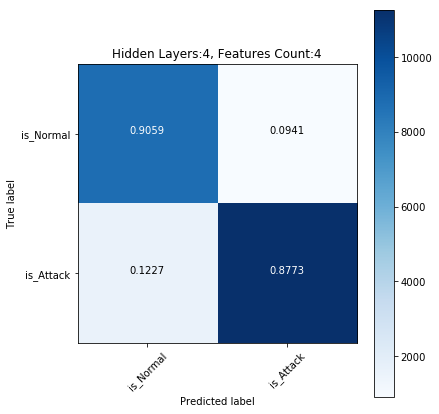

In [ ]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.7063  0.2937]
 [ 0.1477  0.8523]]


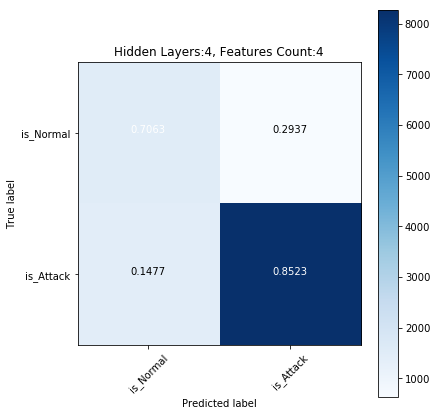

In [ ]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)